<a href="https://colab.research.google.com/github/mfyuce/deep-learning-with-python-notebooks/blob/master/chapter04_classification-and-regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is a companion notebook for the book [Deep Learning with Python, Third Edition](https://www.manning.com/books/deep-learning-with-python-third-edition). For readability, it only contains runnable code blocks and section titles, and omits everything else in the book: text paragraphs, figures, and pseudocode.

**If you want to be able to follow what's going on, I recommend reading the notebook side by side with your copy of the book.**

The book's contents are available online at [deeplearningwithpython.io](https://deeplearningwithpython.io).

In [17]:
!pip install keras keras-hub --upgrade -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 57.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 76.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
keras-nlp 0.21.1 requires keras-hub==0.21.1, but you have keras-hub 0.26.0 which is incompatible.


In [18]:
import os
os.environ["KERAS_BACKEND"] = "jax"

In [19]:
# @title
import os
from IPython.core.magic import register_cell_magic

@register_cell_magic
def backend(line, cell):
    current, required = os.environ.get("KERAS_BACKEND", ""), line.split()[-1]
    if current == required:
        get_ipython().run_cell(cell)
    else:
        print(
            f"This cell requires the {required} backend. To run it, change KERAS_BACKEND to "
            f"\"{required}\" at the top of the notebook, restart the runtime, and rerun the notebook."
        )

## Classification and regression

### Classifying movie reviews: A binary classification example

#### The IMDb dataset

In [20]:
from keras.datasets import imdb

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(
    num_words=10000
)

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [21]:
train_data[0]

[1,
 14,
 22,
 16,
 43,
 530,
 973,
 1622,
 1385,
 65,
 458,
 4468,
 66,
 3941,
 4,
 173,
 36,
 256,
 5,
 25,
 100,
 43,
 838,
 112,
 50,
 670,
 2,
 9,
 35,
 480,
 284,
 5,
 150,
 4,
 172,
 112,
 167,
 2,
 336,
 385,
 39,
 4,
 172,
 4536,
 1111,
 17,
 546,
 38,
 13,
 447,
 4,
 192,
 50,
 16,
 6,
 147,
 2025,
 19,
 14,
 22,
 4,
 1920,
 4613,
 469,
 4,
 22,
 71,
 87,
 12,
 16,
 43,
 530,
 38,
 76,
 15,
 13,
 1247,
 4,
 22,
 17,
 515,
 17,
 12,
 16,
 626,
 18,
 2,
 5,
 62,
 386,
 12,
 8,
 316,
 8,
 106,
 5,
 4,
 2223,
 5244,
 16,
 480,
 66,
 3785,
 33,
 4,
 130,
 12,
 16,
 38,
 619,
 5,
 25,
 124,
 51,
 36,
 135,
 48,
 25,
 1415,
 33,
 6,
 22,
 12,
 215,
 28,
 77,
 52,
 5,
 14,
 407,
 16,
 82,
 2,
 8,
 4,
 107,
 117,
 5952,
 15,
 256,
 4,
 2,
 7,
 3766,
 5,
 723,
 36,
 71,
 43,
 530,
 476,
 26,
 400,
 317,
 46,
 7,
 4,
 2,
 1029,
 13,
 104,
 88,
 4,
 381,
 15,
 297,
 98,
 32,
 2071,
 56,
 26,
 141,
 6,
 194,
 7486,
 18,
 4,
 226,
 22,
 21,
 134,
 476,
 26,
 480,
 5,
 144,
 30,
 5535,
 18,

In [22]:
train_labels[0]

np.int64(1)

In [23]:
max([max(sequence) for sequence in train_data])

9999

In [24]:
word_index = imdb.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
decoded_review = " ".join(
    [reverse_word_index.get(i - 3, "?") for i in train_data[0]]
)

1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 1s 1us/step


In [25]:
decoded_review[:100]

"? this film was just brilliant casting location scenery story direction everyone's really suited the"

#### Preparing the data

In [26]:
import numpy as np

def multi_hot_encode(sequences, num_classes):
    results = np.zeros((len(sequences), num_classes))
    for i, sequence in enumerate(sequences):
        results[i][sequence] = 1.0
    return results

x_train = multi_hot_encode(train_data, num_classes=10000)
x_test = multi_hot_encode(test_data, num_classes=10000)

In [27]:
x_train[0]

array([0., 1., 1., ..., 0., 0., 0.])

In [28]:
y_train = train_labels.astype("float32")
y_test = test_labels.astype("float32")

#### Building your model

In [29]:
import keras
from keras import layers

model = keras.Sequential(
    [
        layers.Dense(16, activation="relu"),
        layers.Dense(16, activation="relu"),
        layers.Dense(1, activation="sigmoid"),
    ]
)

In [30]:
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

#### Validating your approach

In [31]:
x_val = x_train[:10000]
partial_x_train = x_train[10000:]
y_val = y_train[:10000]
partial_y_train = y_train[10000:]

In [32]:
history = model.fit(
    partial_x_train,
    partial_y_train,
    epochs=20,
    batch_size=512,
    validation_data=(x_val, y_val),
)

Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 0.6208 - loss: 0.6484 - val_accuracy: 0.8481 - val_loss: 0.4636
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.8953 - loss: 0.3775 - val_accuracy: 0.8839 - val_loss: 0.3132
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9295 - loss: 0.2283 - val_accuracy: 0.8873 - val_loss: 0.2852
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9546 - loss: 0.1655 - val_accuracy: 0.8894 - val_loss: 0.2787
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9652 - loss: 0.1254 - val_accuracy: 0.8862 - val_loss: 0.2890
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9767 - loss: 0.0978 - val_accuracy: 0.8812 - val_loss: 0.3114
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9860 - loss: 0.0770 - val_accuracy: 0.8802 - val_loss: 0.3290
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9908 - loss: 0.0587 - val_accuracy: 0.8795 - 

In [33]:
history = model.fit(
    x_train,
    y_train,
    epochs=20,
    batch_size=512,
    validation_split=0.2,
)

Epoch 1/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.9272 - loss: 0.2870 - val_accuracy: 0.9778 - val_loss: 0.0908
Epoch 2/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.9613 - loss: 0.1211 - val_accuracy: 0.9666 - val_loss: 0.0895
Epoch 3/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.9772 - loss: 0.0765 - val_accuracy: 0.9614 - val_loss: 0.1005
Epoch 4/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.9868 - loss: 0.0542 - val_accuracy: 0.9578 - val_loss: 0.1143
Epoch 5/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.9916 - loss: 0.0402 - val_accuracy: 0.9522 - val_loss: 0.1285
Epoch 6/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9961 - loss: 0.0281 - val_accuracy: 0.9498 - val_loss: 0.1440
Epoch 7/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9967 - loss: 0.0240 - val_accuracy: 0.9456 - val_loss: 0.1540
Epoch 8/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9984 - loss: 0.0179 - val_accuracy: 0.9418 - v

In [34]:
history_dict = history.history
history_dict.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

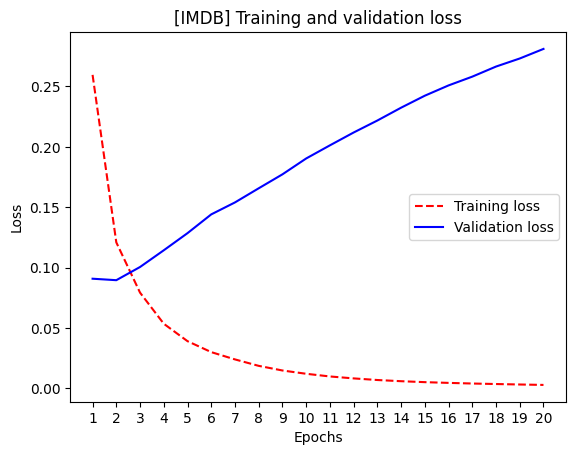

In [35]:
import matplotlib.pyplot as plt

history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "r--", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("[IMDB] Training and validation loss")
plt.xlabel("Epochs")
plt.xticks(epochs)
plt.ylabel("Loss")
plt.legend()
plt.show()

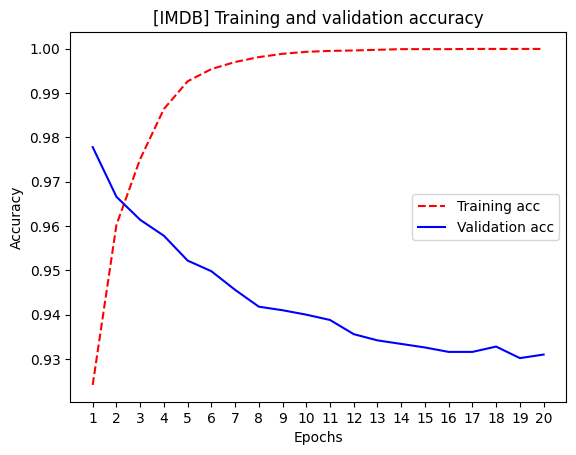

In [36]:
plt.clf()
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
plt.plot(epochs, acc, "r--", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("[IMDB] Training and validation accuracy")
plt.xlabel("Epochs")
plt.xticks(epochs)
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [37]:
model = keras.Sequential(
    [
        layers.Dense(16, activation="relu"),
        layers.Dense(16, activation="relu"),
        layers.Dense(1, activation="sigmoid"),
    ]
)
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(x_train, y_train, epochs=4, batch_size=512)
results = model.evaluate(x_test, y_test)

Epoch 1/4
49/49 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - accuracy: 0.6467 - loss: 0.6141
Epoch 2/4
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9136 - loss: 0.2588
Epoch 3/4
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9431 - loss: 0.1745
Epoch 4/4
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.9596 - loss: 0.1284
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8761 - loss: 0.3227


In [38]:
results

[0.32044485211372375, 0.8781599998474121]

#### Using a trained model to generate predictions on new data

In [39]:
model.predict(x_test)

782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


array([[0.13176964],
       [0.9989963 ],
       [0.49192628],
       ...,
       [0.10468105],
       [0.04825755],
       [0.63343877]], dtype=float32)

#### Further experiments

#### Wrapping up

### Classifying newswires: A multiclass classification example

#### The Reuters dataset

In [62]:
from keras.datasets import reuters

(train_data, train_labels), (test_data, test_labels) = reuters.load_data(
    num_words=10000
)

In [41]:
len(train_data)

8982

In [42]:
len(test_data)

2246

In [43]:
train_data[10]

[1,
 245,
 273,
 207,
 156,
 53,
 74,
 160,
 26,
 14,
 46,
 296,
 26,
 39,
 74,
 2979,
 3554,
 14,
 46,
 4689,
 4329,
 86,
 61,
 3499,
 4795,
 14,
 61,
 451,
 4329,
 17,
 12]

In [63]:
word_index = reuters.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
decoded_newswire = " ".join(
    [reverse_word_index.get(i - 3, "?") for i in train_data[10]]
)

In [45]:
train_labels[10]

np.int64(3)

#### Preparing the data

In [64]:
x_train = multi_hot_encode(train_data, num_classes=10000)
x_test = multi_hot_encode(test_data, num_classes=10000)

In [65]:
def one_hot_encode(labels, num_classes=46):
    results = np.zeros((len(labels), num_classes))
    for i, label in enumerate(labels):
        results[i, label] = 1.0
    return results

y_train = one_hot_encode(train_labels)
y_test = one_hot_encode(test_labels)

In [66]:
from keras.utils import to_categorical

y_train = to_categorical(train_labels)
y_test = to_categorical(test_labels)

#### Building your model

In [69]:
model = keras.Sequential(
    [
        layers.Dense(64, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(46, activation="softmax"),
    ]
)

In [58]:
import keras
from keras import layers

model = keras.Sequential(
    [
        layers.Dense(16, activation="relu"),
        layers.Dense(16, activation="relu"),
        layers.Dense(1, activation="sigmoid"),
    ]
)

In [70]:
top_3_accuracy = keras.metrics.TopKCategoricalAccuracy(
    k=3, name="top_3_accuracy"
)
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy", top_3_accuracy],
)

#### Validating your approach

In [71]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]
y_val = y_train[:1000]
partial_y_train = y_train[1000:]

In [72]:
history = model.fit(
    partial_x_train,
    partial_y_train,
    epochs=20,
    batch_size=512,
    validation_data=(x_val, y_val),
)

Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 0.2490 - loss: 3.6474 - top_3_accuracy: 0.3823 - val_accuracy: 0.5420 - val_loss: 2.8162 - val_top_3_accuracy: 0.7000
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5734 - loss: 2.4903 - top_3_accuracy: 0.7232 - val_accuracy: 0.6110 - val_loss: 1.9034 - val_top_3_accuracy: 0.7420
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6634 - loss: 1.6465 - top_3_accuracy: 0.7724 - val_accuracy: 0.6920 - val_loss: 1.4001 - val_top_3_accuracy: 0.7990
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7331 - loss: 1.2049 - top_3_accuracy: 0.8314 - val_accuracy: 0.7350 - val_loss: 1.1895 - val_top_3_accuracy: 0.8390
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7920 - loss: 0.9453 - top_3_accuracy: 0.8804 - val_accuracy: 0.7680 - val_loss: 1.0750 - val_top_3_accuracy: 0.8690
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8446 - loss: 0.7338 - top_3_a

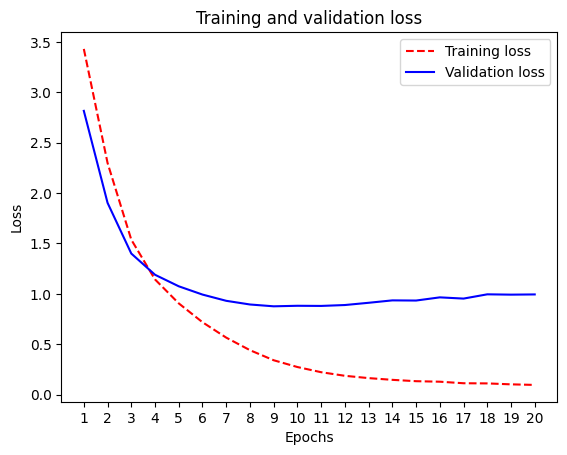

In [73]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, "r--", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.xticks(epochs)
plt.ylabel("Loss")
plt.legend()
plt.show()

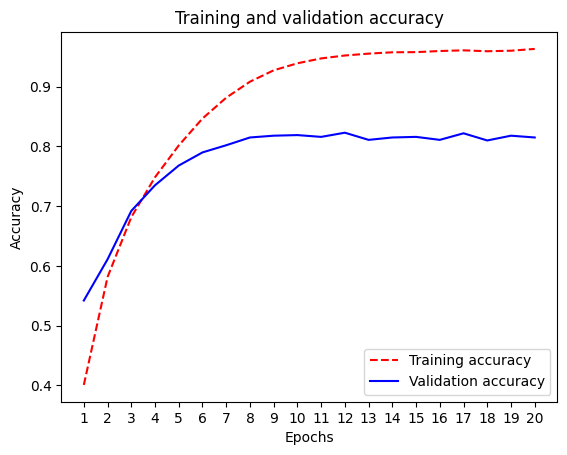

In [74]:
plt.clf()
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
plt.plot(epochs, acc, "r--", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.xticks(epochs)
plt.ylabel("Accuracy")
plt.legend()
plt.show()

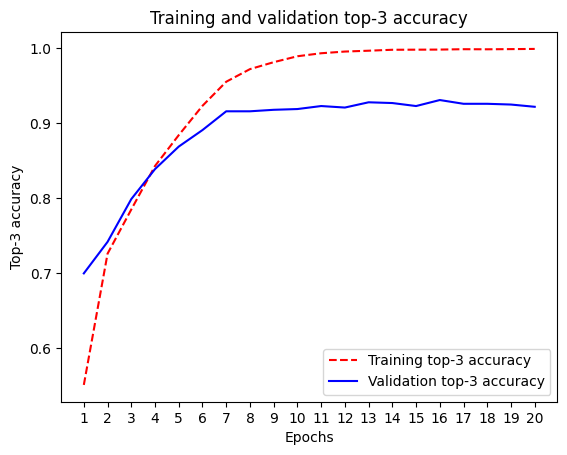

In [75]:
plt.clf()
acc = history.history["top_3_accuracy"]
val_acc = history.history["val_top_3_accuracy"]
plt.plot(epochs, acc, "r--", label="Training top-3 accuracy")
plt.plot(epochs, val_acc, "b", label="Validation top-3 accuracy")
plt.title("Training and validation top-3 accuracy")
plt.xlabel("Epochs")
plt.xticks(epochs)
plt.ylabel("Top-3 accuracy")
plt.legend()
plt.show()

In [76]:
model = keras.Sequential(
    [
        layers.Dense(64, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(46, activation="softmax"),
    ]
)
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    x_train,
    y_train,
    epochs=9,
    batch_size=512,
)
results = model.evaluate(x_test, y_test)

Epoch 1/9
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 0.3635 - loss: 3.4798
Epoch 2/9
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.6004 - loss: 1.9694
Epoch 3/9
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.7096 - loss: 1.3192
Epoch 4/9
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7658 - loss: 1.0413
Epoch 5/9
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8293 - loss: 0.7948
Epoch 6/9
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8679 - loss: 0.6301
Epoch 7/9
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9038 - loss: 0.4775
Epoch 8/9
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9237 - loss: 0.3819
Epoch 9/9
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9405 - loss: 0.2774
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8073 - loss: 0.9086


In [ ]:
results

In [77]:
import copy
test_labels_copy = copy.copy(test_labels)
np.random.shuffle(test_labels_copy)
hits_array = np.array(test_labels == test_labels_copy)
hits_array.mean()

np.float64(0.1981300089047195)

#### Generating predictions on new data

In [78]:
predictions = model.predict(x_test)

71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


In [79]:
predictions[0].shape

(46,)

In [80]:
np.sum(predictions[0])

np.float32(1.0000001)

In [81]:
np.argmax(predictions[0])

np.int64(3)

#### A different way to handle the labels and the loss

In [82]:
y_train = train_labels
y_test = test_labels

In [83]:
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

#### The importance of having sufficiently large intermediate layers

In [84]:
model = keras.Sequential(
    [
        layers.Dense(64, activation="relu"),
        layers.Dense(4, activation="relu"),
        layers.Dense(46, activation="softmax"),
    ]
)
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    partial_x_train,
    partial_y_train,
    epochs=20,
    batch_size=128,
    validation_data=(x_val, y_val),
)

Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.0718 - loss: 3.7414 - val_accuracy: 0.0100 - val_loss: 3.1760
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2137 - loss: 2.7388 - val_accuracy: 0.6010 - val_loss: 1.6607
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6465 - loss: 1.4719 - val_accuracy: 0.6510 - val_loss: 1.4796
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7121 - loss: 1.1620 - val_accuracy: 0.6710 - val_loss: 1.4054
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7216 - loss: 1.0764 - val_accuracy: 0.6750 - val_loss: 1.3928
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7397 - loss: 0.9512 - val_accuracy: 0.6810 - val_loss: 1.3973
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7452 - loss: 0.8946 - val_accuracy: 0.6710 - val_loss: 1.4352
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7461 - loss: 0.8426 - val_accuracy: 0.6740 - val_loss

#### Further experiments

#### Wrapping up

### Predicting house prices: A regression example

#### The California Housing Price dataset

In [85]:
from keras.datasets import california_housing

(train_data, train_targets), (test_data, test_targets) = (
    california_housing.load_data(version="small")
)

743530/743530 ━━━━━━━━━━━━━━━━━━━━ 1s 1us/step


In [86]:
train_data.shape

(480, 8)

In [87]:
test_data.shape

(120, 8)

In [88]:
train_targets

array([228400., 132900.,  60000.,  95200., 107000., 122500., 132000.,
       290100., 257800., 390100., 220800., 284900.,  97500., 415300.,
        84200., 185600., 216700., 233100., 127000., 182300.,  92300.,
        90700., 102100., 112500., 350700., 156500., 220700., 147400.,
       216700., 275000., 198200., 119100., 289500., 152500., 125000.,
       104500.,  93800.,  89300., 452600., 128600., 311500.,  90000.,
       218200., 131300.,  67500., 139400., 500001., 182600., 111300.,
       112500., 134700.,  71300., 207400., 331400., 107900.,  87500.,
       342200.,  87100., 314700., 368600., 211600., 338900., 366100.,
       164300.,  91700., 261400., 218500., 155400., 273700.,  81800.,
       138800.,  99700., 156300., 140600., 152700., 108900., 351200.,
       126000., 137500., 196900., 240000., 172800., 254200.,  97500.,
       182700., 162500.,  86100., 226700., 412500., 165900., 327100.,
       162500., 188800., 183800.,  90600., 372000., 275000., 151800.,
       125000., 1291

#### Preparing the data

In [89]:
mean = train_data.mean(axis=0)
std = train_data.std(axis=0)
x_train = (train_data - mean) / std
x_test = (test_data - mean) / std

In [90]:
y_train = train_targets / 100000
y_test = test_targets / 100000

#### Building your model

In [91]:
def get_model():
    model = keras.Sequential(
        [
            layers.Dense(64, activation="relu"),
            layers.Dense(64, activation="relu"),
            layers.Dense(1),
        ]
    )
    model.compile(
        optimizer="adam",
        loss="mean_squared_error",
        metrics=["mean_absolute_error"],
    )
    return model

#### Validating your approach using K-fold validation

In [92]:
k = 4
num_val_samples = len(x_train) // k
num_epochs = 50
all_scores = []
for i in range(k):
    print(f"Processing fold #{i + 1}")
    fold_x_val = x_train[i * num_val_samples : (i + 1) * num_val_samples]
    fold_y_val = y_train[i * num_val_samples : (i + 1) * num_val_samples]
    fold_x_train = np.concatenate(
        [x_train[: i * num_val_samples], x_train[(i + 1) * num_val_samples :]],
        axis=0,
    )
    fold_y_train = np.concatenate(
        [y_train[: i * num_val_samples], y_train[(i + 1) * num_val_samples :]],
        axis=0,
    )
    model = get_model()
    model.fit(
        fold_x_train,
        fold_y_train,
        epochs=num_epochs,
        batch_size=16,
        verbose=0,
    )
    scores = model.evaluate(fold_x_val, fold_y_val, verbose=0)
    val_loss, val_mae = scores
    all_scores.append(val_mae)

Processing fold #1
Processing fold #2
Processing fold #3
Processing fold #4


In [93]:
[round(value, 3) for value in all_scores]

[0.294, 0.275, 0.275, 0.313]

In [94]:
round(np.mean(all_scores), 3)

np.float64(0.289)

In [95]:
k = 4
num_val_samples = len(x_train) // k
num_epochs = 200
all_mae_histories = []
for i in range(k):
    print(f"Processing fold #{i + 1}")
    fold_x_val = x_train[i * num_val_samples : (i + 1) * num_val_samples]
    fold_y_val = y_train[i * num_val_samples : (i + 1) * num_val_samples]
    fold_x_train = np.concatenate(
        [x_train[: i * num_val_samples], x_train[(i + 1) * num_val_samples :]],
        axis=0,
    )
    fold_y_train = np.concatenate(
        [y_train[: i * num_val_samples], y_train[(i + 1) * num_val_samples :]],
        axis=0,
    )
    model = get_model()
    history = model.fit(
        fold_x_train,
        fold_y_train,
        validation_data=(fold_x_val, fold_y_val),
        epochs=num_epochs,
        batch_size=16,
        verbose=0,
    )
    mae_history = history.history["val_mean_absolute_error"]
    all_mae_histories.append(mae_history)

Processing fold #1
Processing fold #2
Processing fold #3
Processing fold #4


In [96]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)
]

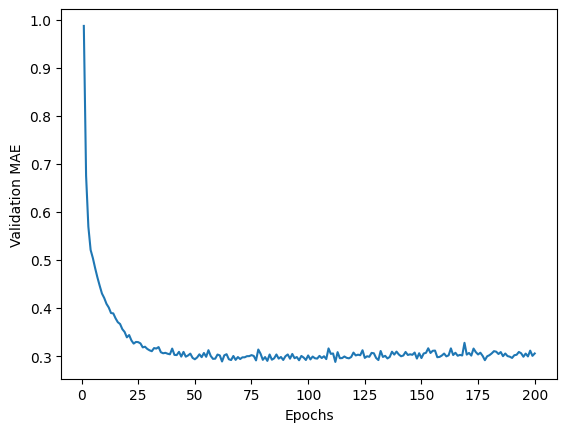

In [97]:
epochs = range(1, len(average_mae_history) + 1)
plt.plot(epochs, average_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

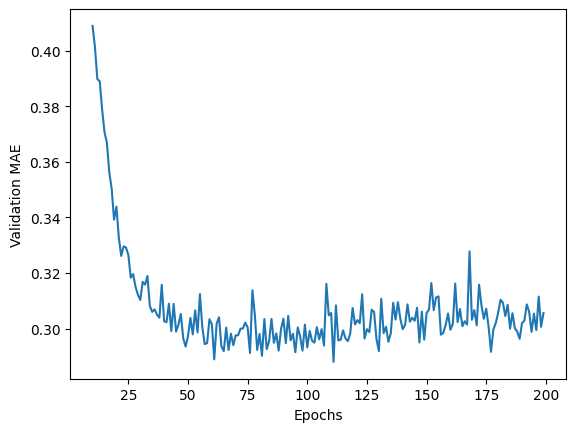

In [98]:
truncated_mae_history = average_mae_history[10:]
epochs = range(10, len(truncated_mae_history) + 10)
plt.plot(epochs, truncated_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

In [99]:
model = get_model()
model.fit(x_train, y_train, epochs=130, batch_size=16, verbose=0)
test_mean_squared_error, test_mean_absolute_error = model.evaluate(
    x_test, y_test
)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.3094 - mean_absolute_error: 0.3225


In [100]:
round(test_mean_absolute_error, 3)

0.306

#### Generating predictions on new data

In [101]:
predictions = model.predict(x_test)
predictions[0]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


array([2.659489], dtype=float32)

#### Wrapping up